## Execution Auction Simulation – Data Visualization

This notebook is designed to analyze simulation results from the execution auction model.
All configuration and logic is defined outside this notebook, in the following files:
- main.py

- player.py

- auction.py

- player_setup.py

This data visualization notebook performs:
- Extraction of round-by-round simulation data

- Flattening results into a player-round DataFrame

- Visualization and analysis of the data

The goal is to examine whether submission time or player type affects winning or profit outcomes in the sealed-bid  first price auction setting.

### 1. Run Simulation and Extract Results
**Note: Simulation parameters live in external modules. We execute main.py directly to inherit its configuration.**

In [ ]:
import runpy
from auction import Auction
from player_setup import generate_players
from player import ReactiveGaussianRangePlayer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from player import ReactiveGaussianRangePlayer, GaussianRangePlayer


# Execute main.py to use its internal config and run simulation
main_ns = runpy.run_module("main", run_name="__main__")
players       = main_ns["players"]
round_results = main_ns.get("round_results") or main_ns.get("round_results", main_ns.get("round_results"))
winnings      = main_ns["winnings"]
print(f"Imported simulation: {len(round_results):,} rounds, {len(players)} players")

# Flatten results into one row per player per round
rows = []
for rnd, rd in enumerate(round_results):
    cutoff = rd["cutoff_time"]
    winner_id, winning_bid, winning_profit = rd["winner"] or (None, None, 0.0)

    for p in players:
        strat_code, bid_prop, submit_time = rd["strategies"][p.player_id]
        valuation = rd["valuations"][p.player_id]
        bid_amount = bid_prop * valuation

        rows.append({
            "round":        rnd,
            "player_id":    p.player_id,
            "reactive":     isinstance(p, ReactiveGaussianRangePlayer),
            "submit_time":  submit_time,
            "cutoff_time":  cutoff,
            "valuation":    valuation,
            "bid_prop":     bid_prop,
            "bid_amount":   bid_amount,
            "won":          int(p.player_id == winner_id),
            "profit":       winning_profit if p.player_id == winner_id else 0.0
        })

# Create DataFrame
df = pd.DataFrame(rows)
print(df.shape)
df.head()


===== First 5 Round(s) Details ======

--- Round 1 --- Cutoff Time: 0.9962
Winner: P4 (Gaussian) | Bid: 0.9713 | Profit: 0.0010
ID   Type      Valuation  Bid        Submit Time   Status
------------------------------------------------------------
P3   Gaussian  0.2966     0.2578     0.0844        ON TIME
P5   Gaussian  0.5886     0.5010     0.1763        ON TIME
P0   Reactive  0.3068     0.3065     0.5368        ON TIME
P9   Gaussian  0.3550     0.3530     0.1838        ON TIME
P6   Reactive  0.6192     0.6186     0.6448        ON TIME
P4   Gaussian  0.9723     0.9713     0.4032        ON TIME
P7   Reactive  0.3665     0.3244     0.4394        ON TIME
P2   Reactive  0.1185     0.1184     0.7267        ON TIME
P1   Gaussian  0.3139     0.1505     0.4310        ON TIME
P8   Reactive  0.7742     0.7734     0.4395        ON TIME

--- Round 2 --- Cutoff Time: 0.9548
Winner: P6 (Reactive) | Bid: 0.8349 | Profit: 0.0008
ID   Type      Valuation  Bid        Submit Time   Status
--------------

,round,player_id,reactive,submit_time,cutoff_time,valuation,bid_prop,bid_amount,won,profit
0,0,3,False,0.084430,0.996222,0.355001,0.257754,0.091503,0,0.0
1,0,5,False,0.176289,0.996222,0.972279,0.500986,0.487098,0,0.0
2,0,0,True,0.536797,0.996222,0.296551,0.306494,0.090891,0,0.0
3,0,9,False,0.183755,0.996222,0.774222,0.352956,0.273266,0,0.0
4,0,6,True,0.644820,0.996222,0.366530,0.618614,0.226741,0,0.0


#### Save Results to CSV (Optional) Save Results to CSV

In [ ]:
# Uncomment to save results for later use
# df.to_csv("auction_rounds.csv", index=False)
# print("Exported to auction_rounds.csv")

#### Check sanity counts

In [6]:
print("\nUnique players :", df['player_id'].nunique())
print("Reactive count :", df['reactive'].sum())
print("Non-reactive   :", (~df['reactive']).sum())
print("Rounds covered :", df['round'].nunique())
print("Bid amount :", df['bid_amount'].describe())

# Missing values check
print("\nNull values per column:")
print(df.isna().sum())


Unique players : 10
Reactive count : 50000
Non-reactive   : 50000
Rounds covered : 10000
Bid amount : count    1.000000e+05
mean     2.253767e-01
std      2.062825e-01
min      6.764087e-07
25%      5.926527e-02
50%      1.627999e-01
75%      3.400315e-01
max      9.942301e-01
Name: bid_amount, dtype: float64

Null values per column:
round          0
player_id      0
reactive       0
submit_time    0
cutoff_time    0
valuation      0
bid_prop       0
bid_amount     0
won            0
profit         0
dtype: int64


### 2. Submit-Time Distribution by Player Type

Purpose: Check whether reactive players really submit later, and if the timing separation works as intended.

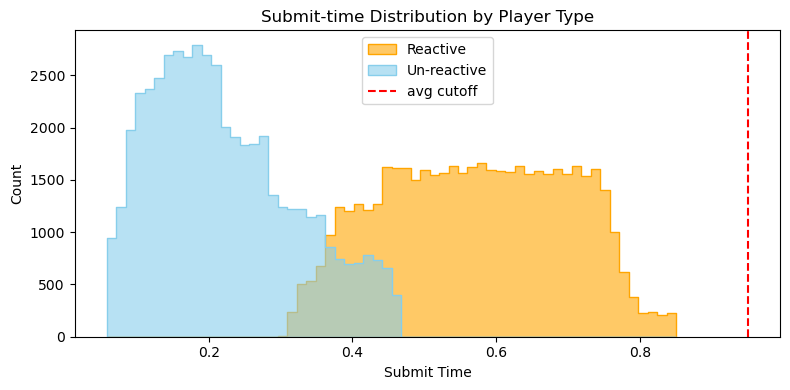

In [18]:
# Submit-time histogram, split by type
plt.figure(figsize=(8,4))
sns.histplot(
    data=df,
    x='submit_time',
    hue='reactive',
    bins=60,
    palette=['skyblue','orange'],
    alpha=0.6,
    element='step'
)
plt.axvline(df['cutoff_time'].mean(), ls='--', color='red', label='avg cutoff')
plt.title('Submit-time Distribution by Player Type')
plt.xlabel('Submit Time')
plt.ylabel('Count')
plt.legend(labels=["Reactive", "Un-reactive", "avg cutoff",])
plt.tight_layout()
plt.show()

### 3. Overall Win Rate vs Submit-Time Quartile

Purpose: Assess whether later bid submissions correlate with higher likelihood of winning, regardless of player type.

/var/folders/pb/13c3__v53fv1pb31p3pyq38m0000gn/T/ipykernel_27137/630737638.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rate = df.groupby('time_q')['won'].mean()


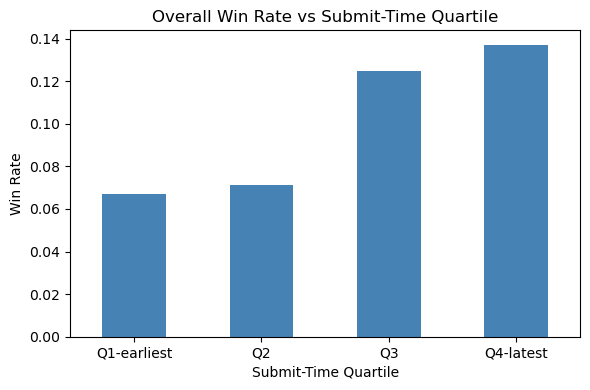

In [19]:
df['time_q'] = pd.qcut(
    df['submit_time'], 4,
    labels=["Q1-earliest","Q2","Q3","Q4-latest"])
win_rate = df.groupby('time_q')['won'].mean()

plt.figure(figsize=(6,4))
win_rate.plot(
    kind='bar',
    color='steelblue')

plt.title('Overall Win Rate vs Submit-Time Quartile')
plt.xticks(rotation=0)
plt.xlabel('Submit-Time Quartile')
plt.ylabel('Win Rate')
plt.tight_layout()
plt.show()

Summary: The bar chart reveals whether win probability increases in later quartiles. A flat or declining trend would indicate that timing alone does not confer a competitive edge.

### 4. Win Rate by Submit-Time Quartile and Player Type
Purpose: Determine if the impact of submission timing on win probability differs between reactive and un-reactive players.

/var/folders/pb/13c3__v53fv1pb31p3pyq38m0000gn/T/ipykernel_27137/2526469235.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['time_q','reactive'])['won']


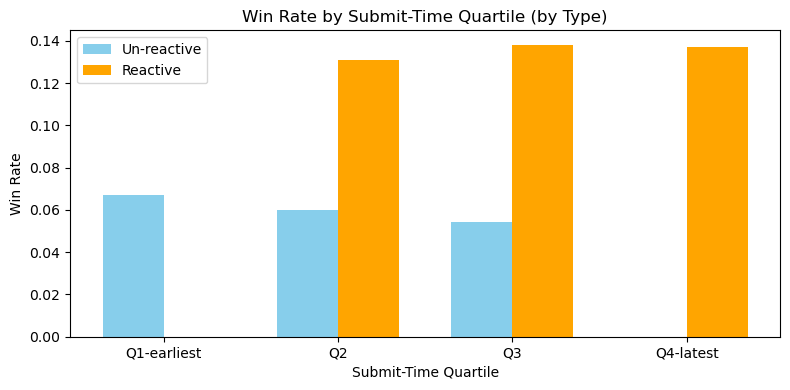

In [20]:
import numpy as np
import matplotlib.pyplot as plt

split_win = (
    df.groupby(['time_q','reactive'])['won']
      .mean()
      .reset_index()
      .pivot(index='time_q', columns='reactive', values='won')
      .rename(columns={False:'Un-reactive', True:'Reactive'})
)

x = np.arange(len(split_win))
width = 0.35
plt.figure(figsize=(8,4))
plt.bar(x - width/2, split_win['Un-reactive'], width,
        label='Un-reactive', color='skyblue')
plt.bar(x + width/2, split_win['Reactive'],   width,
        label='Reactive',   color='orange')
plt.xticks(x, split_win.index)
plt.title('Win Rate by Submit-Time Quartile (by Type)')
plt.xlabel('Submit-Time Quartile')
plt.ylabel('Win Rate')
plt.legend()
plt.tight_layout()
plt.show()

Summary: Comparing within-type bars shows if reactive players still win more often from later submissions, and whether un-reactive players ever benefit from timing. Diverging slopes indicate type-specific timing effects.

### 5. Total and Average Profit by Player Type
Purpose: Compare aggregate earnings to determine which player type achieves greater economic benefit over all rounds.

In [21]:
# Total profit grouped by player type
print("Total Profit by Type:")
print(
    df.groupby('reactive')['profit'].sum()
      .rename({False:'Un-reactive', True:'Reactive'})
)

# Average profit per player in each type
print("\nAverage Profit per Player:")
avg_profit = (
    df.groupby(['player_id','reactive'])['profit'].sum()
      .reset_index()
      .groupby('reactive')['profit'].mean()
      .rename({False:'Un-reactive', True:'Reactive'})
)
print(avg_profit)

Total Profit by Type:
reactive
Un-reactive    98.719988
Reactive       19.992545
Name: profit, dtype: float64

Average Profit per Player:
reactive
Un-reactive    19.743998
Reactive        3.998509
Name: profit, dtype: float64


Summary: These summary quantify whether one group outperforms the other in total and per-player profit, indicating if timing or strategy yields greater economic advantage.

### 6. Profit per Win by Submit-Time Quartile and Player Type
Purpose: Evaluate whether winners who submit later secure higher profit margins, and whether this differs by player type.

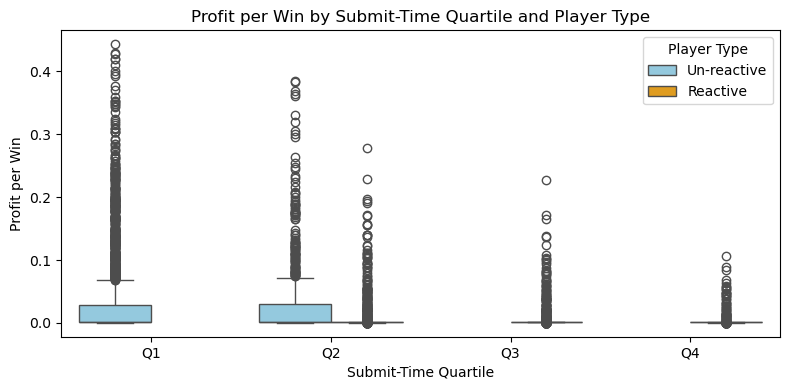

In [22]:
winners = df[df['won']==1].copy()
winners['quartile'] = pd.qcut(
    winners['submit_time'], 4,
    labels=["Q1","Q2","Q3","Q4"]
)
winners['type'] = winners['reactive'].map({True:'Reactive', False:'Un-reactive'})

plt.figure(figsize=(8,4))
sns.boxplot(
    data=winners,
    x='quartile',
    y='profit',
    hue='type',
    palette=['skyblue','orange']
)
plt.title('Profit per Win by Submit-Time Quartile and Player Type')
plt.xlabel('Submit-Time Quartile')
plt.ylabel('Profit per Win')
plt.legend(title='Player Type')
plt.tight_layout()
plt.show()